In [1]:
import torch 
import torchvision
import torch.nn as nn
import torchvision.models as models
import torchvision.models.resnet as resnet_weights
from torchvision.transforms import transforms 
from torch.utils.data import DataLoader,Dataset 

In [2]:
model = models.resnet18(weights=resnet_weights.ResNet18_Weights.IMAGENET1K_V1)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
model.fc = nn.Linear(in_features=model.fc.in_features,out_features=4)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 冻结部分参数 

In [4]:
for param in model.parameters(): 
    param.requires_grad = False
for param in model.fc.parameters(): 
    param.requires_grad = True

In [5]:
transforms_Train = transforms.Compose(
     [
        #数据增强 
        transforms.Resize(224),
        transforms.RandomCrop(192),
        transforms.RandomHorizontalFlip(), #随机水平翻转 
        transforms.RandomRotation(degrees=20), #随机旋转  
        transforms.ColorJitter(brightness=0.5), #随机扰动
        transforms.ColorJitter(contrast=0.5), #增加对比度
        # transforms.Resize((192,192)), 
        transforms.ToTensor(), 
        transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5]),
        
        
    ]
)

In [6]:
transforms_Tst = transforms.Compose(
    [
        transforms.Resize((192,192)),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5])
    ]
)

In [7]:
Train_DS = torchvision.datasets.ImageFolder(
    '../01计算机视觉基础/4weather/train', 
    transform = transforms_Train
)
Tst_DS = torchvision.datasets.ImageFolder(
    '../01计算机视觉基础/4weather/test/', 
    transform=transforms_Tst
)

In [8]:
Train_DL = DataLoader(Train_DS,batch_size=32,shuffle=True)
Tst_DL = DataLoader(Tst_DS,batch_size=64,shuffle=False)

In [9]:
#设置优化器 ,因为我们已经冻结了原来的层,这时候只需要关注最后一层就可以了
optimizer = torch.optim.Adam(model.fc.parameters(),lr=0.0001) #学习率不要太高,因为已经训练好了
#设置损失函数 
loss_fn = nn.CrossEntropyLoss()

In [10]:
def fit_gpu(Train_DL,TST_DL,Model_m,epoch_,optim,loss_fn): 
    correct = 0
    total = 0
    running_loss = 0
    tstcorrect = 0
    tsttotal = 0
    tstrunning_loss = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Model_m.to(device)
  
    Model_m.train()  # 设置为训练模式,此时dropout层会发挥作用
    for x, y in Train_DL:
        x = x.to(device)
        y = y.to(device)
        
        y_pred = Model_m(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()

        # 每个epoch结束后评估模型
        # 所有 batch 都训练完后，再计算整个 epoch 的准确率和损失
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)  #沿着类别维度找到最大值的索引位置
            correct += (y_pred == y).sum().item() #预测正确的个数
            # 因为(y_pred == y).sum()是一个张量,所以为了等式可以数值操作,我们用.item()取值
            total += y.size(0) #样本的个数,也就是size返回值的第一个返回值,即行数
            running_loss += loss.item()

        
    epoch_acc = correct/total
    epoch_loss = running_loss/len(Train_DL.dataset)

    #测试阶段 
    Model_m.eval() #转为eval()模式,此时dropout层不会起作用
    with torch.no_grad(): #测试不需要反向传播,而是用训练好的模型来测试测试集的数据
         for x, y in TST_DL:
             x, y = x.to(device), y.to(device)
             y_pred =Model_m(x)
             loss = loss_fn(y_pred, y)
             
             y_pred = torch.argmax(y_pred,dim=1)   #获取真正的预测结果,不懂就往上巴拉argmax
             tstcorrect += (y_pred == y).sum().item() #预测正确的个数
             tsttotal += y.size(0) #样本的个数
             tstrunning_loss += loss.item()
             
    tstepoch_acc = tstcorrect/tsttotal
    tstepoch_loss = tstrunning_loss/len(TST_DL.dataset)

    print(
        f'epoch:{epoch} | loss:{epoch_loss:.3f} | acc:{epoch_acc:.3f} | tstloss:{tstepoch_loss:.3f} | tstacc:{tstepoch_acc:.3f}'
    )

    return epoch_loss,epoch_acc,tstepoch_loss,tstepoch_acc


In [11]:
optimizer.param_groups

[{'params': [Parameter containing:
   tensor([[-0.0414,  0.0348,  0.0388,  ...,  0.0296,  0.0256, -0.0241],
           [ 0.0108, -0.0267, -0.0415,  ...,  0.0316, -0.0147, -0.0259],
           [-0.0162, -0.0200, -0.0046,  ..., -0.0143, -0.0079,  0.0046],
           [ 0.0002, -0.0217,  0.0339,  ..., -0.0251,  0.0179, -0.0276]],
          requires_grad=True),
   Parameter containing:
   tensor([-0.0271,  0.0339, -0.0232, -0.0177], requires_grad=True)],
  'lr': 0.0001,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False,
  'maximize': False,
  'foreach': None,
  'capturable': False,
  'differentiable': False,
  'fused': None,
  'decoupled_weight_decay': False}]

In [12]:

from torch.optim.lr_scheduler import StepLR
import copy
best_state = copy.deepcopy(model.state_dict()) 
best_acc = 0 
scheduler = StepLR(optimizer=optimizer, step_size=5, gamma=0.9) #设置指定的优化器衰减策略,每5个epoch衰减一次,指定每次的被乘因子为0.9
train_loss_gpu = []
train_acc_gpu = []
tst_loss_gpu = []
tst_acc_gpu = []
epochs = 10

for epoch in range(epochs):
      # 每个 epoch 都训练
    epoch_loss, epoch_acc, tstepoch_loss, tstepoch_acc = fit_gpu(
        Train_DL=Train_DL,
        TST_DL=Tst_DL,
        Model_m=model,
        epoch_=epoch,
        optim=optimizer,
        loss_fn=loss_fn
    )
    #如果测试集的精确度大于最优精确度的话就更新精确度
    if tstepoch_acc > best_acc: 
        best_state = copy.deepcopy(model.state_dict())
        best_acc = epoch_acc
    # 记录指标
    train_loss_gpu.append(epoch_loss)
    train_acc_gpu.append(epoch_acc)
    tst_loss_gpu.append(tstepoch_loss)
    tst_acc_gpu.append(tstepoch_acc)
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}: 学习率已更新为 {current_lr:.2e}")

epoch:0 | loss:0.045 | acc:0.326 | tstloss:0.027 | tstacc:0.160
Epoch 1: 学习率已更新为 1.00e-04
epoch:1 | loss:0.042 | acc:0.386 | tstloss:0.024 | tstacc:0.258
Epoch 2: 学习率已更新为 1.00e-04
epoch:2 | loss:0.039 | acc:0.473 | tstloss:0.023 | tstacc:0.302
Epoch 3: 学习率已更新为 1.00e-04
epoch:3 | loss:0.037 | acc:0.511 | tstloss:0.022 | tstacc:0.409
Epoch 4: 学习率已更新为 1.00e-04
epoch:4 | loss:0.035 | acc:0.596 | tstloss:0.021 | tstacc:0.484
Epoch 5: 学习率已更新为 9.00e-05
epoch:5 | loss:0.032 | acc:0.653 | tstloss:0.019 | tstacc:0.529
Epoch 6: 学习率已更新为 9.00e-05
epoch:6 | loss:0.031 | acc:0.697 | tstloss:0.019 | tstacc:0.613
Epoch 7: 学习率已更新为 9.00e-05
epoch:7 | loss:0.029 | acc:0.727 | tstloss:0.018 | tstacc:0.636
Epoch 8: 学习率已更新为 9.00e-05
epoch:8 | loss:0.029 | acc:0.747 | tstloss:0.017 | tstacc:0.653
Epoch 9: 学习率已更新为 9.00e-05
epoch:9 | loss:0.028 | acc:0.756 | tstloss:0.016 | tstacc:0.662
Epoch 10: 学习率已更新为 8.10e-05


## 解冻所有层,进入微调阶段 

In [13]:
for param in model.parameters(): 
    param.requires_grad = True

当你修改了哪些参数需要更新后，必须重新定义优化器，否则它仍然只会更新原来那些 requires_grad=True 的参数

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # 更小的学习率更适合微调

In [15]:

from torch.optim.lr_scheduler import StepLR
import copy
best_state = copy.deepcopy(model.state_dict()) 
best_acc = 0 
scheduler = StepLR(optimizer=optimizer, step_size=5, gamma=0.9) #设置指定的优化器衰减策略,每5个epoch衰减一次,指定每次的被乘因子为0.9
# train_loss_gpu = []
# train_acc_gpu = []
# tst_loss_gpu = []
# tst_acc_gpu = []
ex_epochs = 10

for epoch in range(ex_epochs):
      # 每个 epoch 都训练
    epoch_loss, epoch_acc, tstepoch_loss, tstepoch_acc = fit_gpu(
        Train_DL=Train_DL,
        TST_DL=Tst_DL,
        Model_m=model,
        epoch_=epoch,
        optim=optimizer,
        loss_fn=loss_fn
    )
    #如果测试集的精确度大于最优精确度的话就更新精确度
    if tstepoch_acc > best_acc: 
        best_state = copy.deepcopy(model.state_dict())
        best_acc = tstepoch_acc
    # 记录指标
    train_loss_gpu.append(epoch_loss)
    train_acc_gpu.append(epoch_acc)
    tst_loss_gpu.append(tstepoch_loss)
    tst_acc_gpu.append(tstepoch_acc)
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}: 学习率已更新为 {current_lr:.2e}")

epoch:0 | loss:0.010 | acc:0.917 | tstloss:0.003 | tstacc:0.938
Epoch 1: 学习率已更新为 1.00e-04
epoch:1 | loss:0.004 | acc:0.966 | tstloss:0.002 | tstacc:0.951
Epoch 2: 学习率已更新为 1.00e-04
epoch:2 | loss:0.004 | acc:0.957 | tstloss:0.002 | tstacc:0.942
Epoch 3: 学习率已更新为 1.00e-04
epoch:3 | loss:0.004 | acc:0.954 | tstloss:0.003 | tstacc:0.942
Epoch 4: 学习率已更新为 1.00e-04
epoch:4 | loss:0.004 | acc:0.956 | tstloss:0.002 | tstacc:0.956
Epoch 5: 学习率已更新为 9.00e-05
epoch:5 | loss:0.003 | acc:0.971 | tstloss:0.004 | tstacc:0.933
Epoch 6: 学习率已更新为 9.00e-05
epoch:6 | loss:0.002 | acc:0.973 | tstloss:0.002 | tstacc:0.964
Epoch 7: 学习率已更新为 9.00e-05
epoch:7 | loss:0.002 | acc:0.983 | tstloss:0.003 | tstacc:0.938
Epoch 8: 学习率已更新为 9.00e-05
epoch:8 | loss:0.003 | acc:0.980 | tstloss:0.003 | tstacc:0.951
Epoch 9: 学习率已更新为 9.00e-05
epoch:9 | loss:0.002 | acc:0.984 | tstloss:0.004 | tstacc:0.951
Epoch 10: 学习率已更新为 8.10e-05


In [16]:
torch.save(best_state,'./models/model_ptform.pt')

## 进行迁移学习 

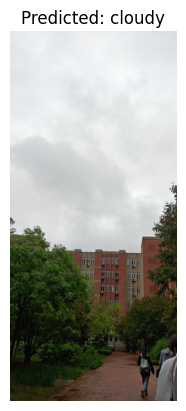

预测天气为: cloudy


In [17]:
from PIL import Image
import matplotlib.pyplot as plt
# 类别名称（必须与训练时一致）
class_names = ['cloudy','rain','shine','sunrise']

# # 实例化模型
model = models.resnet18(weights=None)

model.fc = torch.nn.Linear(512, 4)  # 注意这里改成 4 类
# # 加载权重
model.load_state_dict(torch.load('./models/model_ptform.pt'))

# 检查是否有可用的GPU，如果有则使用，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 确保模型位于正确的设备上
model.to(device)


model.eval()  # 设置为评估模式

# 图像预处理（必须和训练时一致）
transform = transforms.Compose(
   [
        #数据增强 
        transforms.Resize(224),
        transforms.RandomCrop(192),
        transforms.RandomHorizontalFlip(), #随机水平翻转 
        transforms.RandomRotation(degrees=20), #随机旋转  
        transforms.ColorJitter(brightness=0.5), #随机扰动
        transforms.ColorJitter(contrast=0.5), #增加对比度
        # transforms.Resize((192,192)), 
        transforms.ToTensor(), 
        transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5]),
        
        
    ]
)

# 读取图像
image_path = '../01计算机视觉基础/P20250517-081628.jpg'
image = Image.open(image_path).convert('RGB')

# 预处理 + 添加 batch 维度 (1, C, H, W)
image_tensor = transform(image).unsqueeze(0)
# 将输入数据移动到相同的设备上
image_tensor = image_tensor.to(device)
# 推理
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted_idx = torch.max(outputs, 1)
    predicted_class = class_names[predicted_idx.item()]

# 可视化结果
plt.imshow(image)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

print(f"预测天气为: {predicted_class}")

## 进入评测阶段 

In [18]:
# # 实例化模型
model = models.resnet18(weights=None)

model.fc = torch.nn.Linear(512, 4)  # 注意这里改成 4 类
# # 加载权重
model.load_state_dict(best_state)

# 检查是否有可用的GPU，如果有则使用，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 确保模型位于正确的设备上
model.to(device)
correct = 0
total = 0
running_loss = 0
tstcorrect = 0
tsttotal = 0
tstrunning_loss = 0
model.eval() #转为eval()模式,此时dropout层不会起作用
with torch.no_grad(): #测试不需要反向传播,而是用训练好的模型来测试测试集的数据
     for x, y in Tst_DL:
         x, y = x.to(device), y.to(device)
         y_pred=model(x)
         loss = loss_fn(y_pred, y)
         y_pred = torch.argmax(y_pred,dim=1)   #获取真正的预测结果,不懂就往上巴拉argmax
         tstcorrect += (y_pred == y).sum().item() #预测正确的个数
         tsttotal += y.size(0) #样本的个数
         tstrunning_loss += loss.item()
             
tstepoch_acc = tstcorrect/tsttotal
tstepoch_loss = tstrunning_loss/len(Tst_DL.dataset)
print(tstepoch_acc)

0.9644444444444444


## 保存为torchscript格式

In [20]:
# # 加载最优模型参数
# model.load_state_dict(best_state)

# # 设置为评估模式
# model.eval()

# # 创建一个示例输入张量，确保与模型训练时使用的输入形状一致
# example_input = torch.rand(1, 3, 192, 192)

# # 使用 trace 跟踪模型行为
# traced_script_module = torch.jit.trace(model, example_input)

# # 保存为 .pt 文件
# traced_script_module.save("./models/weather_classifier.pt")

# 确保模型在评估模式
model.eval()

# 设置为 GPU 模式（如果你使用了 CUDA）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 创建一个示例输入，并放到与模型相同的设备上
example_input = torch.rand(1, 3, 192, 192).to(device)

# 使用 trace 跟踪模型行为
traced_script_module = torch.jit.trace(model, example_input)

# 保存为 .pt 文件
traced_script_module.save("./models/weather_classifier.pt")

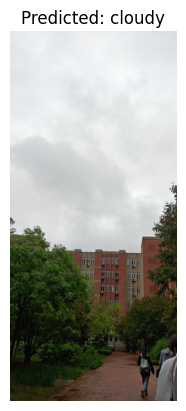

预测天气为: cloudy


In [28]:
from PIL import Image
import matplotlib.pyplot as plt
# 类别名称（必须与训练时一致）
class_names = ['cloudy','rain','shine','sunrise']
# 检查是否有可用的GPU，如果有则使用，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model=torch.jit.load('./models/weather_classifier.pt',map_location=device)



model.eval()  # 设置为评估模式

# 图像预处理（必须和训练时一致）
transform = transforms.Compose(
 [
        transforms.Resize((192,192)),
        transforms.ToTensor()
        
    ]
)

# 读取图像
image_path = '../01计算机视觉基础/P20250517-081628.jpg'
image = Image.open(image_path).convert('RGB')

# 预处理 + 添加 batch 维度 (1, C, H, W)
image_tensor = transform(image).unsqueeze(0)
# 将输入数据移动到相同的设备上
image_tensor = image_tensor.to(device)
# 推理
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted_idx = torch.max(outputs, 1)
    predicted_class = class_names[predicted_idx.item()]

# 可视化结果
plt.imshow(image)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

print(f"预测天气为: {predicted_class}")

## 转换为ONNX 

In [26]:
import torch

# 加载 TorchScript 模型
model = torch.jit.load('./models/weather_classifier.pt')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# 设置模型为评估模式
model.eval()

# 创建一个示例输入张量，确保其尺寸与训练时一致
example_input = torch.randn(1, 3, 192, 192).to(device)

# 导出模型为 ONNX 格式
torch.onnx.export(model,
                  example_input,  # 模型的输入 (或者一个元组对于多输入模型)
                  "./models/weather_classifier.onnx",  # 输出的 ONNX 文件名
                  input_names=["input"],  # 输入的名字
                  output_names=["output"],  # 输出的名字
                  opset_version=11,  # ONNX 版本，根据你的需求调整
                  dynamic_axes={'input': {0: 'batch_size'},  # 动态轴设置，这里设置了 batch_size 可变
                                'output': {0: 'batch_size'}})

print("模型已成功导出为 ONNX 格式")

D:\venvs\dl\Lib\site-packages\torch\onnx\utils.py:814: UserWarning: no signature found for builtin <built-in method __call__ of PyCapsule object at 0x00000180EF1505D0>, skipping _decide_input_format
  warnings.warn(f"{e}, skipping _decide_input_format")


模型已成功导出为 ONNX 格式


你看到的这条信息：

```
D:\venvs\dl\Lib\site-packages\torch\onnx\utils.py:814: UserWarning: no signature found for builtin <built-in method __call__ of PyCapsule object at 0x00000180EF1505D0>, skipping _decide_input_format
  warnings.warn(f"{e}, skipping _decide_input_format")
```

---

## 🟡 它只是一个 **Warning（警告）**，不是错误（Error）

也就是说，它 **不会阻止你的模型导出成功**，但说明 PyTorch 的 ONNX 导出器在尝试分析模型结构时，遇到了一个它无法解析的内置函数或模块（比如某些 TorchScript 封装的模块）。

---

## 🧠 警告含义解释

- `__call__ of PyCapsule object`：表示 PyTorch 遇到了一个封装过的底层 C++ 对象（通常是 `torch.ScriptModule` 或 `torch.ScriptFunction`，即你用 `torch.jit.script()` 或 `torch.jit.trace()` 保存的模型）。
- `no signature found`：ONNX 导出器尝试分析这个模块的输入输出格式，但找不到 Python 层面的函数签名（因为是编译后的 TorchScript 模块）。
- `skipping _decide_input_format`：跳过了对输入格式的自动推断步骤。

---

## ✅ 是否需要处理这个警告？

### 🔹 情况一：模型已经成功导出为 ONNX ✅

如果你的 ONNX 模型已经成功生成，并且你可以用 `onnx.checker.check_model()` 验证通过，或者在 ONNX Runtime 中正常推理，**那这个警告可以忽略**。

### 🔹 情况二：模型导出失败 ❌

如果模型导出失败，你需要看的是 **错误信息（Error）**，而不是这个警告。请继续提供完整的错误堆栈，我们来分析具体问题。

---

## ✅ 如何避免这个警告（可选）

如果你希望去掉这个警告，可以考虑以下方法：

### 方法 1：使用原始模型（非 TorchScript）导出 ONNX

如果你有原始的 PyTorch 模型定义（比如 `ResNet` 类），并且你不是从 `.pt` 文件加载的 TorchScript 模型，而是重新构建模型结构并加载了权重，那么导出时就不会遇到这个警告。

```python
model = MyModel()
model.load_state_dict(torch.load("model.pth"))
model.eval()
torch.onnx.export(model, ...)
```

### 方法 2：忽略警告（调试阶段）

如果你只是想忽略这个警告，可以在代码中临时屏蔽：

```python
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.onnx.utils")

# 然后继续导出 ONNX 模型
```

---

## ✅ 总结

| 内容 | 说明 |
|------|------|
| **警告内容** | `no signature found for builtin ...` |
| **是否严重** | ❗ 不是错误，不影响导出结果 |
| **是否可以忽略** | ✅ 可以忽略，前提是模型能成功导出并验证 |
| **如何避免** | 使用原始 PyTorch 模型导出，或忽略警告 |
| **建议操作** | 继续测试 ONNX 模型是否可用，无需担心这个警告 |

---

如果你已经导出 `.onnx` 文件，欢迎继续提问：

- 如何用 ONNX Runtime 推理？
- 如何可视化 ONNX 模型结构？
- 如何用 TensorRT 加速 ONNX 模型？

我可以一步步带你部署和优化 😎

In [27]:
model

RecursiveScriptModule(
  original_name=ResNet
  (conv1): RecursiveScriptModule(original_name=Conv2d)
  (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
  (relu): RecursiveScriptModule(original_name=ReLU)
  (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
  (layer1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=BasicBlock
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (relu): RecursiveScriptModule(original_name=ReLU)
      (conv2): RecursiveScriptModule(original_name=Conv2d)
      (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
    )
    (1): RecursiveScriptModule(
      original_name=BasicBlock
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
      (relu): RecursiveScriptModule(original_name=ReLU)
      (conv2): RecursiveScriptModule(original_name=Conv2d)

In [ ]:
import numpy as np
import onnxruntime as ort
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 类别名称（必须与训练时一致）
class_names = ['cloudy', 'rain', 'shine', 'sunrise']

# 加载 ONNX 模型
ort_session = ort.InferenceSession("weather_classifier.onnx")

# 图像预处理（必须与训练时一致）
# 图像预处理（必须和训练时一致）
transform = transforms.Compose(
   [
        #数据增强 
        transforms.Resize(224),
        transforms.CenterCrop(192),  # 使用 CenterCrop 替换 RandomCrop（因为测试时不需要随机裁剪,
        transforms.RandomHorizontalFlip(), #随机水平翻转 
        transforms.RandomRotation(degrees=20), #随机旋转  
        transforms.ColorJitter(brightness=0.5), #随机扰动
        transforms.ColorJitter(contrast=0.5), #增加对比度
        # transforms.Resize((192,192)), 
        transforms.ToTensor(), 
        transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5]),
        
        
    ]
)

# 读取图像
image_path = '../01计算机视觉基础/P20250517-081628.jpg'
image = Image.open(image_path).convert('RGB')

# 预处理图像并转换为 numpy 数组
image_tensor = transform(image).unsqueeze(0)  # 添加 batch 维度 (1, C, H, W)
image_np = image_tensor.numpy()  # ONNX Runtime 接受 numpy 输入

# 推理
outputs = ort_session.run(
    None,
    {'input': image_np}  # 'input' 是导出时定义的输入名称
)

# 解析输出结果
predicted_idx = np.argmax(outputs[0], axis=0)
predicted_class = class_names[predicted_idx]

# 可视化结果
plt.imshow(image)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

print(f"预测天气为: {predicted_class}")

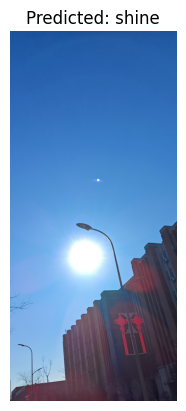

预测天气为: shine


In [31]:
import numpy as np 
import onnxruntime as ort
from PIL import Image
# 类别名称（必须与训练时一致）
class_names = ['cloudy','rain','shine','sunrise']

# 加载 ONNX 模型
ort_session = ort.InferenceSession("weather_classifier.onnx")


model.eval()  # 设置为评估模式

# 图像预处理（必须和训练时一致）
transform = transforms.Compose(
   [
        #数据增强 
        transforms.Resize(224),
        transforms.CenterCrop(192),  # 使用 CenterCrop 替换 RandomCrop（因为测试时不需要随机裁剪,
        transforms.ToTensor(), 
        transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5]),  
    ]
)

# 读取图像
image_path = '../01计算机视觉基础/P20250329-081002.jpg'
image = Image.open(image_path).convert('RGB')

# 预处理 + 添加 batch 维度 (1, C, H, W)
image_tensor = transform(image).unsqueeze(0)

image_np = image_tensor.numpy() # ONNX Runtime 接受 numpy 输入


# 推理
outputs = ort_session.run(
    None,
    {'input': image_np}  # 'input' 是导出时定义的输入名称
)

# 解析输出结果
predicted_idx = np.argmax(outputs[0], axis=1)[0]  # 获取预测类别索引
predicted_class = class_names[predicted_idx]

# 可视化结果
plt.imshow(image)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()

print(f"预测天气为: {predicted_class}")